# Una ojeada a la data de apagones en PR

## Nota: Si el texto se ven mal vaya a este a este [enlace](https://nbviewer.org/github/agostof/ApagonesPR/blob/master/src/ExploracionApagones.ipynb).

Recientemente salió a relucir que la data de LUMA que reporta apagones tiene un sinnúmero de problemas. Esto fue reportado por Giancarlo González Áscar ([@giangonz](https://twitter.com/giangonz)), CEO de [Urbital](http://urbital.io), en el programa “Los datos son los datos”.

Uno de los problemas principales que se reportaron fue duplicados y datos inconsistentes, es decir nombres repetidos o múltiples nombres para el mismo lugar. Me pareció interesante el issue y quise ver el problema de primera mano.

El equipo de Urbital creo [Blackouts](https://blackouts.urbital.io) para que la ciudadanía pueda acceder ésta data. 

En éste ejercicio utilizo la data agregada que utiliza este portal interrogando su API. 
El objetivo de este ejercicio de "data exploration":
- ver cuanta data duplicada hay
- ver que métodos se pueden utilizar para la limpieza (data curation)

## TL;DR: Inconsistencias

Existen inconsistencia entre abreviaciones, nombres, duplicaciones y otra nomenclatura. La siguiente figura muestra las palabras populares y da una idea de palabras o fragmentos de nombres repetidos:

> <figure>
> <img src="palabrasFrecuentes.png" style="width:100%">
> <figcaption align = "center"> <strong>WordCloud:</strong> muesta "palabras" con alta frecuencia en dataset de zonas de LUMA. </figcaption>
> </figure>

Aqui un poco mas de detalle de las abreviaciones de distintos tipos de divisiones (zonas o comunidades) observados:
- Barrio: {BO, BO., Bo., Bo, Barrio, BARRIO}
- Barriada: {BDA, BDA., Barriada, BARRIADA}
- Apartamento: {APTO, APT, APTO.}
- Parcelas: {PAR, PAR., PARC, PARC., PARCELA}
- Urbanización: {URB, URB., Urbanizacion, Urb.}
- Sector: {SEC, SECT, SECT., SECTOR, Sector}

Esto nos hace pensar que in buen sitio para comenzar es resolver estas inconsistencias y `normalizar` o `standarizar` los nombres. Luego usando otras fuentes se podira buscar la jerarquía de la zonas, ejemplo: ¿La zona `X` es un sector de un barrio en un pueblo especifico, o una urbanizacion, otra?. 



## Para ver mas detalles ...

Salte a otras partes del documento para ver el procedimiento y el código y/o reproducir los resultados.

> - [Analisis de datos](#Analizando-los-datos)
> - [Para ver los resultados](#Resultados)
> - [Resumen TL;DR](#Resumen-de-resultados)
<!-- (#Resumen-de-resultados) -->



In [2]:
import requests
import json
import time

# vamos a trabajar con la data ya guardada, para bajar data nueva set to True
RELOAD_DATA = False

# Buscando los datos

Usando el API del Blackout App podemos bajar los datos en especial los pueblos y las zonas donde se reportan los apagones.

Primero bajemos la lista de pueblos:

In [3]:
# lista de pueblos
url = 'https://blackouts.urbital.io/towns'
payload = {}
headers = {}
response = requests.request("GET", url, headers=headers, data=payload)

towns = json.loads(response.text)['towns']

# end = "\n"
# print(f'Top 5:\n{ end.join(towns[:5]) }\nTotal: {len(towns)}')
# check a few
towns[:10]


['ADJUNTAS',
 'AGUADA',
 'AGUADILLA',
 'AGUAS BUENAS',
 'AIBONITO',
 'ANASCO',
 'ARECIBO',
 'ARROYO',
 'BARCELONETA',
 'BARRANQUITAS']

## Verificación de los datos

Ahora verifiquemos el número de pueblos. Quermos ver si la cantidad es correcta. 

In [4]:
print(f'Numero de pueblos en datos: {len(towns)}')

Numero de pueblos en datos: 77


¡Oh oh!. Hay un error... Sabemos que Puerto Rico esta dividido en **78** pueblos, no 77, asi que nos falta uno.

Para buscar que pueblo nos falta tenemos que usar una lista de referencia con los pueblos de PR. Por suerte encontre una en este *gist* de [@rubenvarela](https://gist.github.com/rubenvarela/8475772).
Veamos los contenidos de la lista que usaremos como **goldstandard** para los pueblos.
```
Adjuntas
Aguada
Aguadilla
Aguas Buenas
Aibonito
Arecibo
Arroyo
Añasco
Barceloneta
Barranquitas
Bayamón
Cabo Rojo
Caguas
....
```
La lista parece tener todos los pueblos. Al comprar la lista hay que tener en mente dos cosas: el uso de letras mayúsculas y de los acentos diacriticos.

Por ahora bajemos la lista:
``` bash
curl https://gist.githubusercontent.com/rubenvarela/8475772/raw/a8cb51b4a5183f20ac0eea07b4ee655b3327b0f9/gistfile1.txt -LO
```
### Buscando el pueblo que falta
Ahora trabajemos con la lista para identificar el pueblo que falta.

In [5]:
# Leer pueblos
with open('../data/gistfile1.txt') as kown_towns_fp:
    known_towns = []
    for town in kown_towns_fp:
        known_towns.append(town.rstrip())
# Muestra de pueblos
known_towns[:5]


['Adjuntas', 'Aguada', 'Aguadilla', 'Aguas Buenas', 'Aibonito']

Verificamos que si tiene 78 pueblos.

In [6]:
print(f'Numero de pueblos en datos: {len(known_towns)}')

Numero de pueblos en datos: 78


Ahora vamos a convertir los pueblos a mayuscula y a remover los acentos y ñ. Esto solo lo hacemos por que la lista de la base de datos de LUMA (provista por Urbital) no los tiene en *casi todos* los casos.

In [7]:
# create translation table to remove accents
trans_table = str.maketrans("ÁÉÍÓÜÑ", "AEIOUN")
# print("Translated: ","ÁÉÍÓÜÑ".translate(trans_table) )

# trans_table = bytes.maketrans(bytes([ord(i) for i in "ÁÍÓÜÑ"]), bytes([ord(i) for i in "AIOUN"]))
known_towns_noaccent = [i.upper().translate(trans_table) for i in known_towns]

# lets take a quick look
known_towns_noaccent[:5]

['ADJUNTAS', 'AGUADA', 'AGUADILLA', 'AGUAS BUENAS', 'AIBONITO']

Veamos que pueblo nos falta:

In [8]:
# missing towns
set(known_towns_noaccent) - set(towns)

{'ISABELA', 'PENUELAS'}

El pueblo de Peñuelas aparece en las dos listas y ese el unico con Ñ en la lista de Blackout App.

In [9]:
'PEÑUELAS' in towns

True

Tomando esto en cuenta, busquemos el pueblo falta:

In [10]:
set(known_towns_noaccent) - (set(towns) | {'PENUELAS'})

{'ISABELA'}

Con esto identificamos que el pueblo que falta es `Isabela`.

## Bajar las zonas

Ahora bajemos la data sobre las "zonas"—barrios, sectores, urbanizaciones, etc– de cada pueblo.

In [11]:
# bajar las zonas que existen en cada pueblo usando el api
def get_zone(town):
    url = f'https://blackouts.urbital.io/zones/{town}'
    payload={}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)
    
    town_data = json.loads(response.text)
    return town_data
    

In [12]:
# if need to re-run the data download set RELOAD_DATA = True
zone_data = {}
import time
for town in towns:
    print(f'pueblo: {town}')
    if RELOAD_DATA:
        zone_data[town] = get_zone(town)
        # hacer un poco de throttling para no abusar del API
        time.sleep(0.5)

# guardar la data
if RELOAD_DATA:
    json.dump(zone_data, open("../data/zone_data.json","w"))

pueblo: ADJUNTAS
pueblo: AGUADA
pueblo: AGUADILLA
pueblo: AGUAS BUENAS
pueblo: AIBONITO
pueblo: ANASCO
pueblo: ARECIBO
pueblo: ARROYO
pueblo: BARCELONETA
pueblo: BARRANQUITAS
pueblo: BAYAMON
pueblo: CABO ROJO
pueblo: CAGUAS
pueblo: CAMUY
pueblo: CANOVANAS
pueblo: CAROLINA
pueblo: CATANO
pueblo: CAYEY
pueblo: CEIBA
pueblo: CIALES
pueblo: CIDRA
pueblo: COAMO
pueblo: COMERIO
pueblo: COROZAL
pueblo: CULEBRA
pueblo: DORADO
pueblo: FAJARDO
pueblo: FLORIDA
pueblo: GUANICA
pueblo: GUAYAMA
pueblo: GUAYANILLA
pueblo: GUAYNABO
pueblo: GURABO
pueblo: HATILLO
pueblo: HORMIGUEROS
pueblo: HUMACAO
pueblo: JAYUYA
pueblo: JUANA DIAZ
pueblo: JUNCOS
pueblo: LAJAS
pueblo: LARES
pueblo: LAS MARIAS
pueblo: LAS PIEDRAS
pueblo: LOIZA
pueblo: LUQUILLO
pueblo: MANATI
pueblo: MARICAO
pueblo: MAUNABO
pueblo: MAYAGUEZ
pueblo: MOCA
pueblo: MOROVIS
pueblo: NAGUABO
pueblo: NARANJITO
pueblo: OROCOVIS
pueblo: PATILLAS
pueblo: PEÑUELAS
pueblo: PONCE
pueblo: QUEBRADILLAS
pueblo: RINCON
pueblo: RIO GRANDE
pueblo: SABANA GR

# Analizando los datos

## Leer la data
Vamos a subir los datos a un dataframe.

In [13]:
# load zone data
import pandas as pd
import json

zone_data = json.load(open('../data/zone_data.json'))
zones_df = pd.DataFrame({(town, len(town_data['zones']), tuple(town_data['zones'])) for town,town_data in zone_data.items()}, columns=['pueblo', 'zn_count','zn_names'])
zones_df = zones_df.sort_values('pueblo', ignore_index=True).reset_index(drop=True)

zones_df.to_csv("../data/zone_data.csv", index=False)
zones_df.head()


,pueblo,zn_count,zn_names
0,ADJUNTAS,395,"(40 CALLE 3, ADJUNTAS, ALTO DE LA BANDERA/BO P..."
1,AGUADA,698,"(AGUADA, AGUADA GARDENS, AguadZU, ASOMANTE, AS..."
2,AGUADILLA,873,"(AguacaB, AGUACATE, AGUACATE DESP ESC CONTINEN..."
3,AGUAS BUENAS,349,"(AGUAS BUENAS, BAIROA, BAIROA/COLIN BO JAGUEYE..."
4,AIBONITO,332,"( - , #3/BO.RABANAL(SE361)/ANTENAS, AIBONITO..."


In [14]:
# zones_all_towns = []
# for town in zone_data:
#     print(town, len(zone_data[town]['zones']))
#     zones_all_towns.append(zone_data[town]['zones'])
    
#len(all_zones)


## Palabras mas frecuentes
Vamos a ver cuales con las palabras mas frecuentes. Utilizaremos un `WordCloud` para una visualización gráfica y luego de forma cuantitativa usando un `Counter`. Esto ayuda a detectar componentes como abreviaciones y mirar su consistencia.

## Proceso de datos
Para poder estudiar la frecuencia de las palabras tenemos que separar los nombres de las zonas en sus componentes individuales.

Por ejemplo, para la zona llamada: *'BO CAPAEZ SEC ALTO LOS CALABOS'* queremos contar en *todas las zonas* cuantas veces aparece cada una de las palabras:
> la zona: 'BO CAPAEZ SEC ALTO LOS CALABOS', queremos contar: `BO`, `CAPAEZ`, `SEC`, `ALTO`, `LOS`, `CALABOS`.

Luego usaremos esos componentes para crear el `WordCloud` y la tabla de frecuencias.

In [15]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import nltk

from collections import Counter
from PIL import Image
from os import path
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

# nltk.download("stopwords")
stopwords = set(stopwords.words('spanish', 'english')) 
stopwords.update( [w.upper() for w in stopwords])

In [16]:
# remove aditional spaces
space_regexp = re.compile("\s\s+")
remove_reduntant_spaces = lambda s:space_regexp.sub(" ", s)
all_zones = []

#for zone in zones_all_towns:
for zones in zones_df.zn_names:
    all_zones.extend(list(map(remove_reduntant_spaces, zones)))
    
from itertools import chain
single_words = list(chain.from_iterable(map(lambda x:x.split(), all_zones)))


# Resultados
## WordCloud
Esta es una buena excusa para crear un `WordCloud`. Con esto vamos a ver cuales abreviaciones o palablas son mas frecuentes, esto estará representado por el tamaño de la palabra.


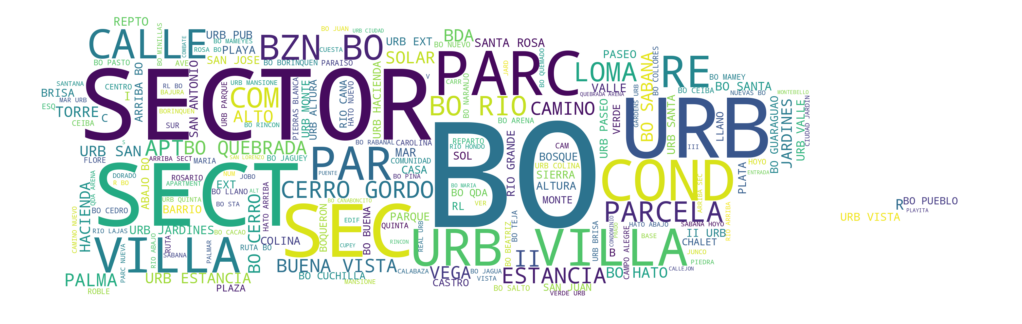

In [17]:
# mapa de PR
mask = np.array(Image.open(path.join("assets", "IslaDePuertoRicoMunicipios.png")))

# Crear worldCloud y usa mapa como mask
wordcloud = WordCloud(width = mask.shape[1], height = mask.shape[0],
                mask=mask,
                background_color ='white',
                stopwords = stopwords,
                #max_words=50,
                #min_font_size = 4,
                #max_font_size=256,
               # margin=10,
                random_state=1).generate(" ".join(single_words))

# mostrar world cloud
plt.figure(figsize = (14, 12), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()
# plt.savefig('PalabrasFrecuentes.png')


### Tabulación de palabras (buscando las más frecuentes)

Vamos a calcular cuantas veces aparece una palabra y mostrar las 50 más frecuentes. Parecido al `WorldCloud`, el motivo de esto es ver y cuantificar cuales abreviaciones o palablas se observan en la data.


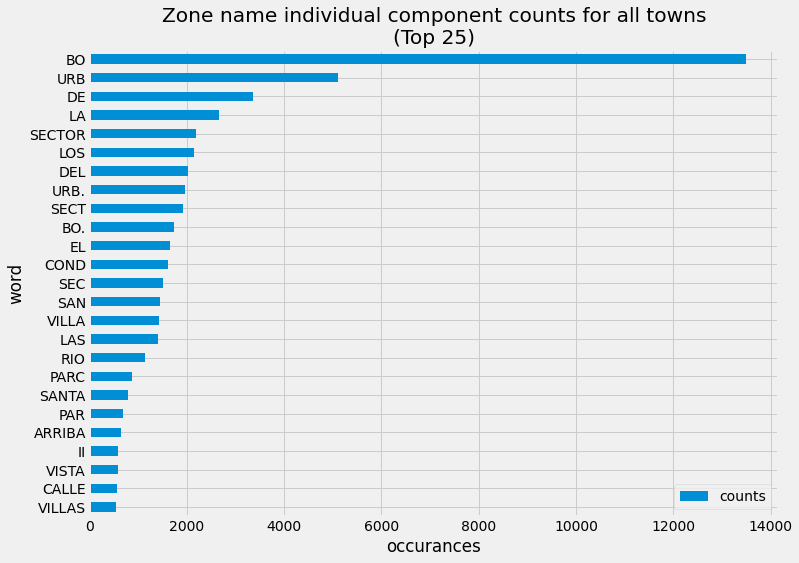

In [18]:
import matplotlib

tabulated_words = Counter(single_words)
word_counts_df = pd.DataFrame.from_records(list(tabulated_words.items()), columns=["word", "counts"])
word_counts_sorted = word_counts_df.sort_values("counts", ascending=False).reset_index(drop=True)

# check styles with: plt.style.available
matplotlib.style.use('fivethirtyeight')
show_count = 25
word_counts_sorted.head(show_count).plot(kind='barh', 
                                 x="word", 
                                 y="counts",
                                 xlabel="occurances",
                                 figsize=(11, 8), 
                                 title=f"Zone name individual component counts for all towns\n(Top {show_count})").invert_yaxis()


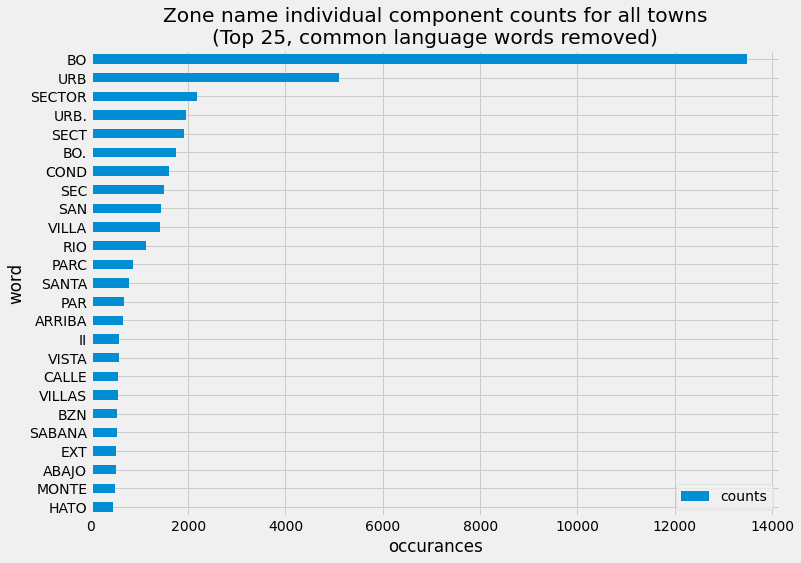

In [19]:
word_counts_sorted.loc[~word_counts_sorted.word.isin(stopwords)].head(show_count).plot(kind='barh', 
                                 x="word", 
                                 y="counts",
                                 xlabel="occurances",
                                 figsize=(11, 8), 
                                 title=f"Zone name individual component counts for all towns\n(Top {show_count}, common language words removed)").invert_yaxis()


In [20]:
# Show top 50 words after removing stopwords sorted alphabetically
word_counts_sorted.loc[~word_counts_sorted.word.isin(stopwords)].head(50).sort_values("word")

,word,counts
36,/,419
49,1,347
32,2,425
28,ABAJO,513
42,ALTO,376
54,ALTURAS,321
20,ARRIBA,656
0,BO,13487
9,BO.,1742
25,BZN,538


In [21]:
# Guardar tablas para revisar patrones.
# 
word_counts_sorted.to_csv("../data/words.sorted.csv", index=False)
word_counts_sorted.loc[word_counts_sorted.word.apply(lambda w:any([symbol in w for symbol in '\-#/.,']))].to_csv("../data/words_wsymbol.csv", index=False)


# Resumen de resultados

Este análisis no es uno comprensivo, pero ayuda a ver varios de los errores comunes que se encuentran en la data. Podemos ver que existe inconsistencia entre abreviaciones de distintos tipos de divisiones (zonas o comunidades), por ejemplo:
- Barrio: {BO, BO., Bo., Bo, Barrio, BARRIO}
- Barriada: {BDA, BDA., Barriada, BARRIADA}
- Apartamento: {APTO, APT, APTO.}
- Parcelas: {PAR, PAR., PARC, PARC., PARCELA}
- Urbanización: {URB, URB., Urbanizacion, Urb.}
- Sector: {SEC, SECT, SECT., SECTOR, Sector}

Un buen sitio para comenzar es resolver estas inconsistencias y `normalizar` o `standarizar` los nombres. Luego usando otras fuentes se podira buscar la jerarquía de la zonas, ejemplo: ¿La zona `X` es un sector de un barrio en un pueblo especifico, o una urbanizacion, otra?. Luego se pueden mirar como remover los duplicados y consolidar la data: [RevisionDuplicados (Draft)](RevisionDuplicados.ipynb).